In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from poisson_glm_granger import compute_granger_causality
from joblib import Parallel, delayed
from statsmodels.stats.multitest import multipletests
from matplotlib.gridspec import GridSpec

In [2]:
subjects=['S1','S2','S3','S5','S6','S7','S8','S10','S11','S13','S14','S15']

def load_subject_data(conditions, subjects, data_path='./Binned'):
    """
    Preload all subject data for all conditions.
    """
    all_data = {cond: [] for cond in conditions}

    for cond in conditions:
        for subject in subjects:
            c3_data = scipy.io.loadmat(f'{data_path}/c3_binned_{cond}_subject_{subject}.mat')
            c3_data = np.moveaxis(c3_data[f'c3_binned_{cond}'], [0,1,2],[0, 2, 1])
            
            f4_data = scipy.io.loadmat(f'{data_path}/f4_binned_{cond}_subject_{subject}.mat')
            f4_data = np.moveaxis(f4_data[f'f4_binned_{cond}'], [0,1,2],[0, 2, 1])

            all_data[cond].append(np.vstack([c3_data, f4_data]))

    return all_data

In [3]:
# Preload data
all_data = load_subject_data(
    conditions=['FS', 'SS', 'GO'],
    subjects=subjects,
    data_path='./Binned'
)

In [8]:
best_windows={
    'FS': [],
    'SS': [],
    'GO': []
}
gc_matrices={
    'FS': [],
    'SS': [],
    'GO': []
}
signed_gc_matrices={
    'FS': [],
    'SS': [],
    'GO': []
}

for s_idx, subject in enumerate(subjects):
    for cond in gc_matrices:
        print(f'{subject} - {cond}')
        X=all_data[cond][s_idx]

        best_window, gc_matrix, signed_gc_matrix = compute_granger_causality(
            X, 
            window_range=(1, 20), 
            folds=10,
            n_jobs=-1
        )
        best_windows[cond].append(best_window)
        gc_matrices[cond].append(gc_matrix)
        signed_gc_matrices[cond].append(signed_gc_matrix)

S1 - FS
Source 0 -> Target 0: Optimal window = 9, CV score = -0.0379
Source 1 -> Target 0: Optimal window = 9, CV score = -0.0380
Source 0 -> Target 1: Optimal window = 8, CV score = -0.0367
Source 1 -> Target 1: Optimal window = 8, CV score = -0.0367
S1 - SS
Source 0 -> Target 0: Optimal window = 18, CV score = -0.0384
Source 1 -> Target 0: Optimal window = 18, CV score = -0.0385
Source 0 -> Target 1: Optimal window = 20, CV score = -0.0349
Source 1 -> Target 1: Optimal window = 20, CV score = -0.0348
S1 - GO
Source 0 -> Target 0: Optimal window = 20, CV score = -0.0389
Source 1 -> Target 0: Optimal window = 20, CV score = -0.0389
Source 0 -> Target 1: Optimal window = 20, CV score = -0.0343
Source 1 -> Target 1: Optimal window = 20, CV score = -0.0342
S2 - FS
Source 0 -> Target 0: Optimal window = 2, CV score = -0.0292
Source 1 -> Target 0: Optimal window = 4, CV score = -0.0292
Source 0 -> Target 1: Optimal window = 4, CV score = -0.0386
Source 1 -> Target 1: Optimal window = 4, CV 

Source 0 -> Target 0: Optimal window = 20, CV score = -0.0344
Source 1 -> Target 0: Optimal window = 20, CV score = -0.0345
Source 0 -> Target 1: Optimal window = 20, CV score = -0.0349
Source 1 -> Target 1: Optimal window = 20, CV score = -0.0349
S15 - FS
Source 0 -> Target 0: Optimal window = 20, CV score = -0.0348
Source 1 -> Target 0: Optimal window = 20, CV score = -0.0348
Source 0 -> Target 1: Optimal window = 7, CV score = -0.0336
Source 1 -> Target 1: Optimal window = 7, CV score = -0.0335
S15 - SS
Source 0 -> Target 0: Optimal window = 20, CV score = -0.0380
Source 1 -> Target 0: Optimal window = 20, CV score = -0.0381
Source 0 -> Target 1: Optimal window = 20, CV score = -0.0342
Source 1 -> Target 1: Optimal window = 20, CV score = -0.0342
S15 - GO
Source 0 -> Target 0: Optimal window = 20, CV score = -0.0371
Source 1 -> Target 0: Optimal window = 20, CV score = -0.0372
Source 0 -> Target 1: Optimal window = 20, CV score = -0.0339
Source 1 -> Target 1: Optimal window = 20, CV

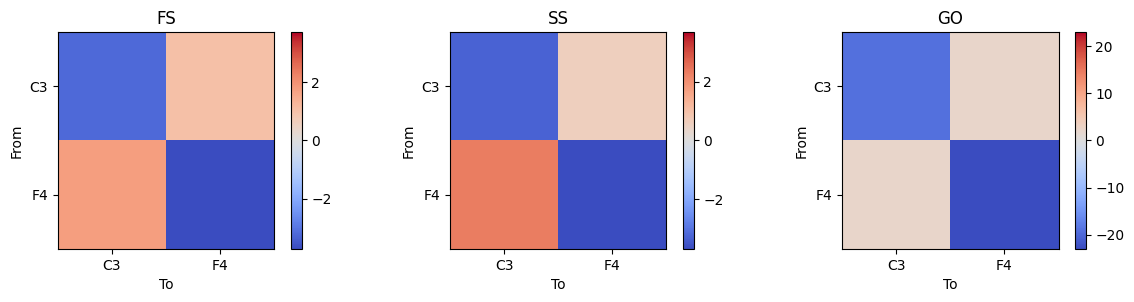

In [9]:
fig=plt.figure(figsize=(12,3))
gs = GridSpec(1, 3)
for cond_idx, cond in enumerate(signed_gc_matrices):
    ax = fig.add_subplot(gs[0,cond_idx])
    gc_mat=np.mean(np.array(signed_gc_matrices[cond]),axis=0)
    maxabs=np.max(np.abs(gc_mat[:]))
    # Display results
    im=plt.imshow(gc_mat, cmap='coolwarm', interpolation='none', clim=[-maxabs, maxabs])
    plt.colorbar()
    plt.title(cond)
    plt.xlabel("To")
    plt.ylabel("From")
    plt.xticks([0,1])
    ax.set_xticklabels(['C3','F4'])
    plt.yticks([0,1])
    ax.set_yticklabels(['C3','F4'])
plt.tight_layout()

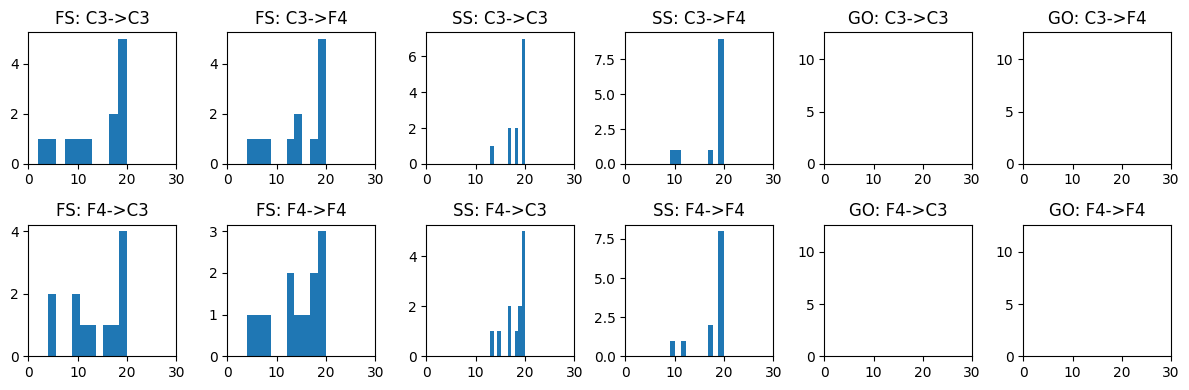

In [10]:
labels=['C3','F4']
fig=plt.figure(figsize=(12,4)) 
gs = GridSpec(2, 6)
for cond_idx, cond in enumerate(signed_gc_matrices):
    for source in range(2):
        for target in range(2):
            ax = fig.add_subplot(gs[source,cond_idx*2+target])
            plt.hist([x[(source,target)][0] for x in best_windows[cond]])
            plt.xlim([0,30])
            plt.title(f'{cond}: {labels[source]}->{labels[target]}')
plt.tight_layout()

In [11]:
def shuffle_trials(data):
    """
    Shuffle trials for all neurons in the data array.

    Parameters:
    ----------
    data : ndarray
        The input data array of shape (neurons, trials, time_steps).

    Returns:
    -------
    ndarray
        A shuffled version of the input data with shuffled trials.
    """
    shuffled_data = data.copy()
    neurons, trials, _ = shuffled_data.shape

    for neuron in range(neurons):
        shuffled_data[neuron, :, :] = shuffled_data[neuron, np.random.permutation(trials), :]
    return shuffled_data


def shuffle_time(data):
    """
    Shuffle time points for all neurons in the data array.

    Parameters:
    ----------
    data : ndarray
        The input data array of shape (neurons, trials, time_steps).

    Returns:
    -------
    ndarray
        A shuffled version of the input data with shuffled time points.
    """
    shuffled_data = data.copy()
    neurons, _, time_steps = shuffled_data.shape

    for neuron in range(neurons):
        for trial in range(shuffled_data.shape[1]):
            shuffled_data[neuron, trial, :] = np.random.permutation(shuffled_data[neuron, trial, :])
    return shuffled_data


# Permutation test with separate shuffling for trials and time
conditions = ['FS', 'SS', 'GO']
n_permutations = 100
alpha = 0.05

neurons = gc_matrices[conditions[0]][0].shape[0]
permuted_gc_matrices = {cond: [] for cond in conditions}
permuted_signed_gc_matrices = {cond: [] for cond in conditions}

# Run permutations one at a time to avoid large memory usage
for perm_idx in range(n_permutations):
    for cond in conditions:
        permuted_gc_matrix = np.zeros((neurons, neurons))
        permuted_signed_gc_matrix = np.zeros((neurons, neurons))
        
        for s_idx, subject_data in enumerate(all_data[cond]):
            print(f'Permutation {perm_idx}, Condition {cond}, Subject {s_idx}')

            # Shuffle trials for off-diagonal elements
            shuffled_trials_X = shuffle_trials(subject_data)
            _, gc_trials, signed_gc_trials = compute_granger_causality(
                shuffled_trials_X,
                n_jobs=-1,
                pairwise_windows=best_windows[cond][s_idx]
            )

            # Shuffle time for diagonal elements
            shuffled_time_X = shuffle_time(subject_data)
            _, gc_time, signed_gc_time = compute_granger_causality(
                shuffled_time_X,
                n_jobs=-1,
                pairwise_windows=best_windows[cond][s_idx]
            )

            # Combine results: diagonal from time shuffling, off-diagonal from trial shuffling
            for i in range(neurons):
                for j in range(neurons):
                    if i == j:
                        permuted_gc_matrix[i, j] += gc_time[i, j]
                        permuted_signed_gc_matrix[i, j] += signed_gc_time[i, j]
                    else:
                        permuted_gc_matrix[i, j] += gc_trials[i, j]
                        permuted_signed_gc_matrix[i, j] += signed_gc_trials[i, j]

        # Average across subjects
        permuted_gc_matrices[cond].append(permuted_gc_matrix / len(subjects))
        permuted_signed_gc_matrices[cond].append(permuted_signed_gc_matrix / len(subjects))


Permutation 0, Condition FS, Subject 0
Permutation 0, Condition FS, Subject 1
Permutation 0, Condition FS, Subject 2
Permutation 0, Condition FS, Subject 3
Permutation 0, Condition FS, Subject 4
Permutation 0, Condition FS, Subject 5
Permutation 0, Condition FS, Subject 6
Permutation 0, Condition FS, Subject 7
Permutation 0, Condition FS, Subject 8
Permutation 0, Condition FS, Subject 9
Permutation 0, Condition FS, Subject 10
Permutation 0, Condition FS, Subject 11
Permutation 0, Condition SS, Subject 0
Permutation 0, Condition SS, Subject 1
Permutation 0, Condition SS, Subject 2
Permutation 0, Condition SS, Subject 3
Permutation 0, Condition SS, Subject 4
Permutation 0, Condition SS, Subject 5
Permutation 0, Condition SS, Subject 6
Permutation 0, Condition SS, Subject 7
Permutation 0, Condition SS, Subject 8
Permutation 0, Condition SS, Subject 9
Permutation 0, Condition SS, Subject 10
Permutation 0, Condition SS, Subject 11
Permutation 0, Condition GO, Subject 0
Permutation 0, Condit

Permutation 5, Condition GO, Subject 6
Permutation 5, Condition GO, Subject 7
Permutation 5, Condition GO, Subject 8
Permutation 5, Condition GO, Subject 9
Permutation 5, Condition GO, Subject 10
Permutation 5, Condition GO, Subject 11
Permutation 6, Condition FS, Subject 0
Permutation 6, Condition FS, Subject 1
Permutation 6, Condition FS, Subject 2
Permutation 6, Condition FS, Subject 3
Permutation 6, Condition FS, Subject 4
Permutation 6, Condition FS, Subject 5
Permutation 6, Condition FS, Subject 6
Permutation 6, Condition FS, Subject 7
Permutation 6, Condition FS, Subject 8
Permutation 6, Condition FS, Subject 9
Permutation 6, Condition FS, Subject 10
Permutation 6, Condition FS, Subject 11
Permutation 6, Condition SS, Subject 0
Permutation 6, Condition SS, Subject 1
Permutation 6, Condition SS, Subject 2
Permutation 6, Condition SS, Subject 3
Permutation 6, Condition SS, Subject 4
Permutation 6, Condition SS, Subject 5
Permutation 6, Condition SS, Subject 6
Permutation 6, Condit

Permutation 11, Condition SS, Subject 10
Permutation 11, Condition SS, Subject 11
Permutation 11, Condition GO, Subject 0
Permutation 11, Condition GO, Subject 1
Permutation 11, Condition GO, Subject 2
Permutation 11, Condition GO, Subject 3
Permutation 11, Condition GO, Subject 4
Permutation 11, Condition GO, Subject 5
Permutation 11, Condition GO, Subject 6
Permutation 11, Condition GO, Subject 7
Permutation 11, Condition GO, Subject 8
Permutation 11, Condition GO, Subject 9
Permutation 11, Condition GO, Subject 10
Permutation 11, Condition GO, Subject 11
Permutation 12, Condition FS, Subject 0
Permutation 12, Condition FS, Subject 1
Permutation 12, Condition FS, Subject 2
Permutation 12, Condition FS, Subject 3
Permutation 12, Condition FS, Subject 4
Permutation 12, Condition FS, Subject 5
Permutation 12, Condition FS, Subject 6
Permutation 12, Condition FS, Subject 7
Permutation 12, Condition FS, Subject 8
Permutation 12, Condition FS, Subject 9
Permutation 12, Condition FS, Subjec

Permutation 17, Condition FS, Subject 10
Permutation 17, Condition FS, Subject 11
Permutation 17, Condition SS, Subject 0
Permutation 17, Condition SS, Subject 1
Permutation 17, Condition SS, Subject 2
Permutation 17, Condition SS, Subject 3
Permutation 17, Condition SS, Subject 4
Permutation 17, Condition SS, Subject 5
Permutation 17, Condition SS, Subject 6
Permutation 17, Condition SS, Subject 7
Permutation 17, Condition SS, Subject 8
Permutation 17, Condition SS, Subject 9
Permutation 17, Condition SS, Subject 10
Permutation 17, Condition SS, Subject 11
Permutation 17, Condition GO, Subject 0
Permutation 17, Condition GO, Subject 1
Permutation 17, Condition GO, Subject 2
Permutation 17, Condition GO, Subject 3
Permutation 17, Condition GO, Subject 4
Permutation 17, Condition GO, Subject 5
Permutation 17, Condition GO, Subject 6
Permutation 17, Condition GO, Subject 7
Permutation 17, Condition GO, Subject 8
Permutation 17, Condition GO, Subject 9
Permutation 17, Condition GO, Subjec

Permutation 22, Condition GO, Subject 10
Permutation 22, Condition GO, Subject 11
Permutation 23, Condition FS, Subject 0
Permutation 23, Condition FS, Subject 1
Permutation 23, Condition FS, Subject 2
Permutation 23, Condition FS, Subject 3
Permutation 23, Condition FS, Subject 4
Permutation 23, Condition FS, Subject 5
Permutation 23, Condition FS, Subject 6
Permutation 23, Condition FS, Subject 7
Permutation 23, Condition FS, Subject 8
Permutation 23, Condition FS, Subject 9
Permutation 23, Condition FS, Subject 10
Permutation 23, Condition FS, Subject 11
Permutation 23, Condition SS, Subject 0
Permutation 23, Condition SS, Subject 1
Permutation 23, Condition SS, Subject 2
Permutation 23, Condition SS, Subject 3
Permutation 23, Condition SS, Subject 4
Permutation 23, Condition SS, Subject 5
Permutation 23, Condition SS, Subject 6
Permutation 23, Condition SS, Subject 7
Permutation 23, Condition SS, Subject 8
Permutation 23, Condition SS, Subject 9
Permutation 23, Condition SS, Subjec

Permutation 28, Condition SS, Subject 10
Permutation 28, Condition SS, Subject 11
Permutation 28, Condition GO, Subject 0
Permutation 28, Condition GO, Subject 1
Permutation 28, Condition GO, Subject 2
Permutation 28, Condition GO, Subject 3
Permutation 28, Condition GO, Subject 4
Permutation 28, Condition GO, Subject 5
Permutation 28, Condition GO, Subject 6
Permutation 28, Condition GO, Subject 7
Permutation 28, Condition GO, Subject 8
Permutation 28, Condition GO, Subject 9
Permutation 28, Condition GO, Subject 10
Permutation 28, Condition GO, Subject 11
Permutation 29, Condition FS, Subject 0
Permutation 29, Condition FS, Subject 1
Permutation 29, Condition FS, Subject 2
Permutation 29, Condition FS, Subject 3
Permutation 29, Condition FS, Subject 4
Permutation 29, Condition FS, Subject 5
Permutation 29, Condition FS, Subject 6
Permutation 29, Condition FS, Subject 7
Permutation 29, Condition FS, Subject 8
Permutation 29, Condition FS, Subject 9
Permutation 29, Condition FS, Subjec

Permutation 34, Condition FS, Subject 10
Permutation 34, Condition FS, Subject 11
Permutation 34, Condition SS, Subject 0
Permutation 34, Condition SS, Subject 1
Permutation 34, Condition SS, Subject 2
Permutation 34, Condition SS, Subject 3
Permutation 34, Condition SS, Subject 4
Permutation 34, Condition SS, Subject 5
Permutation 34, Condition SS, Subject 6
Permutation 34, Condition SS, Subject 7
Permutation 34, Condition SS, Subject 8
Permutation 34, Condition SS, Subject 9
Permutation 34, Condition SS, Subject 10
Permutation 34, Condition SS, Subject 11
Permutation 34, Condition GO, Subject 0
Permutation 34, Condition GO, Subject 1
Permutation 34, Condition GO, Subject 2
Permutation 34, Condition GO, Subject 3
Permutation 34, Condition GO, Subject 4
Permutation 34, Condition GO, Subject 5
Permutation 34, Condition GO, Subject 6
Permutation 34, Condition GO, Subject 7
Permutation 34, Condition GO, Subject 8
Permutation 34, Condition GO, Subject 9
Permutation 34, Condition GO, Subjec

Permutation 39, Condition GO, Subject 10
Permutation 39, Condition GO, Subject 11
Permutation 40, Condition FS, Subject 0
Permutation 40, Condition FS, Subject 1
Permutation 40, Condition FS, Subject 2
Permutation 40, Condition FS, Subject 3
Permutation 40, Condition FS, Subject 4
Permutation 40, Condition FS, Subject 5
Permutation 40, Condition FS, Subject 6
Permutation 40, Condition FS, Subject 7
Permutation 40, Condition FS, Subject 8
Permutation 40, Condition FS, Subject 9
Permutation 40, Condition FS, Subject 10
Permutation 40, Condition FS, Subject 11
Permutation 40, Condition SS, Subject 0
Permutation 40, Condition SS, Subject 1
Permutation 40, Condition SS, Subject 2
Permutation 40, Condition SS, Subject 3
Permutation 40, Condition SS, Subject 4
Permutation 40, Condition SS, Subject 5
Permutation 40, Condition SS, Subject 6
Permutation 40, Condition SS, Subject 7
Permutation 40, Condition SS, Subject 8
Permutation 40, Condition SS, Subject 9
Permutation 40, Condition SS, Subjec

Permutation 45, Condition SS, Subject 10
Permutation 45, Condition SS, Subject 11
Permutation 45, Condition GO, Subject 0
Permutation 45, Condition GO, Subject 1
Permutation 45, Condition GO, Subject 2
Permutation 45, Condition GO, Subject 3
Permutation 45, Condition GO, Subject 4
Permutation 45, Condition GO, Subject 5
Permutation 45, Condition GO, Subject 6
Permutation 45, Condition GO, Subject 7
Permutation 45, Condition GO, Subject 8
Permutation 45, Condition GO, Subject 9
Permutation 45, Condition GO, Subject 10
Permutation 45, Condition GO, Subject 11
Permutation 46, Condition FS, Subject 0
Permutation 46, Condition FS, Subject 1
Permutation 46, Condition FS, Subject 2
Permutation 46, Condition FS, Subject 3
Permutation 46, Condition FS, Subject 4
Permutation 46, Condition FS, Subject 5
Permutation 46, Condition FS, Subject 6
Permutation 46, Condition FS, Subject 7
Permutation 46, Condition FS, Subject 8
Permutation 46, Condition FS, Subject 9
Permutation 46, Condition FS, Subjec

Permutation 51, Condition FS, Subject 10
Permutation 51, Condition FS, Subject 11
Permutation 51, Condition SS, Subject 0
Permutation 51, Condition SS, Subject 1
Permutation 51, Condition SS, Subject 2
Permutation 51, Condition SS, Subject 3
Permutation 51, Condition SS, Subject 4
Permutation 51, Condition SS, Subject 5
Permutation 51, Condition SS, Subject 6
Permutation 51, Condition SS, Subject 7
Permutation 51, Condition SS, Subject 8
Permutation 51, Condition SS, Subject 9
Permutation 51, Condition SS, Subject 10
Permutation 51, Condition SS, Subject 11
Permutation 51, Condition GO, Subject 0
Permutation 51, Condition GO, Subject 1
Permutation 51, Condition GO, Subject 2
Permutation 51, Condition GO, Subject 3
Permutation 51, Condition GO, Subject 4
Permutation 51, Condition GO, Subject 5
Permutation 51, Condition GO, Subject 6
Permutation 51, Condition GO, Subject 7
Permutation 51, Condition GO, Subject 8
Permutation 51, Condition GO, Subject 9
Permutation 51, Condition GO, Subjec

Permutation 56, Condition GO, Subject 10
Permutation 56, Condition GO, Subject 11
Permutation 57, Condition FS, Subject 0
Permutation 57, Condition FS, Subject 1
Permutation 57, Condition FS, Subject 2
Permutation 57, Condition FS, Subject 3
Permutation 57, Condition FS, Subject 4
Permutation 57, Condition FS, Subject 5
Permutation 57, Condition FS, Subject 6
Permutation 57, Condition FS, Subject 7
Permutation 57, Condition FS, Subject 8
Permutation 57, Condition FS, Subject 9
Permutation 57, Condition FS, Subject 10
Permutation 57, Condition FS, Subject 11
Permutation 57, Condition SS, Subject 0
Permutation 57, Condition SS, Subject 1
Permutation 57, Condition SS, Subject 2
Permutation 57, Condition SS, Subject 3
Permutation 57, Condition SS, Subject 4
Permutation 57, Condition SS, Subject 5
Permutation 57, Condition SS, Subject 6
Permutation 57, Condition SS, Subject 7
Permutation 57, Condition SS, Subject 8
Permutation 57, Condition SS, Subject 9
Permutation 57, Condition SS, Subjec

Permutation 62, Condition SS, Subject 10
Permutation 62, Condition SS, Subject 11
Permutation 62, Condition GO, Subject 0
Permutation 62, Condition GO, Subject 1
Permutation 62, Condition GO, Subject 2
Permutation 62, Condition GO, Subject 3
Permutation 62, Condition GO, Subject 4
Permutation 62, Condition GO, Subject 5
Permutation 62, Condition GO, Subject 6
Permutation 62, Condition GO, Subject 7
Permutation 62, Condition GO, Subject 8
Permutation 62, Condition GO, Subject 9
Permutation 62, Condition GO, Subject 10
Permutation 62, Condition GO, Subject 11
Permutation 63, Condition FS, Subject 0
Permutation 63, Condition FS, Subject 1
Permutation 63, Condition FS, Subject 2
Permutation 63, Condition FS, Subject 3
Permutation 63, Condition FS, Subject 4
Permutation 63, Condition FS, Subject 5
Permutation 63, Condition FS, Subject 6
Permutation 63, Condition FS, Subject 7
Permutation 63, Condition FS, Subject 8
Permutation 63, Condition FS, Subject 9
Permutation 63, Condition FS, Subjec

Permutation 68, Condition FS, Subject 10
Permutation 68, Condition FS, Subject 11
Permutation 68, Condition SS, Subject 0
Permutation 68, Condition SS, Subject 1
Permutation 68, Condition SS, Subject 2
Permutation 68, Condition SS, Subject 3
Permutation 68, Condition SS, Subject 4
Permutation 68, Condition SS, Subject 5
Permutation 68, Condition SS, Subject 6
Permutation 68, Condition SS, Subject 7
Permutation 68, Condition SS, Subject 8
Permutation 68, Condition SS, Subject 9
Permutation 68, Condition SS, Subject 10
Permutation 68, Condition SS, Subject 11
Permutation 68, Condition GO, Subject 0
Permutation 68, Condition GO, Subject 1
Permutation 68, Condition GO, Subject 2
Permutation 68, Condition GO, Subject 3
Permutation 68, Condition GO, Subject 4
Permutation 68, Condition GO, Subject 5
Permutation 68, Condition GO, Subject 6
Permutation 68, Condition GO, Subject 7
Permutation 68, Condition GO, Subject 8
Permutation 68, Condition GO, Subject 9
Permutation 68, Condition GO, Subjec

Permutation 73, Condition GO, Subject 10
Permutation 73, Condition GO, Subject 11
Permutation 74, Condition FS, Subject 0
Permutation 74, Condition FS, Subject 1
Permutation 74, Condition FS, Subject 2
Permutation 74, Condition FS, Subject 3
Permutation 74, Condition FS, Subject 4
Permutation 74, Condition FS, Subject 5
Permutation 74, Condition FS, Subject 6
Permutation 74, Condition FS, Subject 7
Permutation 74, Condition FS, Subject 8
Permutation 74, Condition FS, Subject 9
Permutation 74, Condition FS, Subject 10
Permutation 74, Condition FS, Subject 11
Permutation 74, Condition SS, Subject 0
Permutation 74, Condition SS, Subject 1
Permutation 74, Condition SS, Subject 2
Permutation 74, Condition SS, Subject 3
Permutation 74, Condition SS, Subject 4
Permutation 74, Condition SS, Subject 5
Permutation 74, Condition SS, Subject 6
Permutation 74, Condition SS, Subject 7
Permutation 74, Condition SS, Subject 8
Permutation 74, Condition SS, Subject 9
Permutation 74, Condition SS, Subjec

Permutation 79, Condition SS, Subject 10
Permutation 79, Condition SS, Subject 11
Permutation 79, Condition GO, Subject 0
Permutation 79, Condition GO, Subject 1
Permutation 79, Condition GO, Subject 2
Permutation 79, Condition GO, Subject 3
Permutation 79, Condition GO, Subject 4
Permutation 79, Condition GO, Subject 5
Permutation 79, Condition GO, Subject 6
Permutation 79, Condition GO, Subject 7
Permutation 79, Condition GO, Subject 8
Permutation 79, Condition GO, Subject 9
Permutation 79, Condition GO, Subject 10
Permutation 79, Condition GO, Subject 11
Permutation 80, Condition FS, Subject 0
Permutation 80, Condition FS, Subject 1
Permutation 80, Condition FS, Subject 2
Permutation 80, Condition FS, Subject 3
Permutation 80, Condition FS, Subject 4
Permutation 80, Condition FS, Subject 5
Permutation 80, Condition FS, Subject 6
Permutation 80, Condition FS, Subject 7
Permutation 80, Condition FS, Subject 8
Permutation 80, Condition FS, Subject 9
Permutation 80, Condition FS, Subjec

Permutation 85, Condition FS, Subject 10
Permutation 85, Condition FS, Subject 11
Permutation 85, Condition SS, Subject 0
Permutation 85, Condition SS, Subject 1
Permutation 85, Condition SS, Subject 2
Permutation 85, Condition SS, Subject 3
Permutation 85, Condition SS, Subject 4
Permutation 85, Condition SS, Subject 5
Permutation 85, Condition SS, Subject 6
Permutation 85, Condition SS, Subject 7
Permutation 85, Condition SS, Subject 8
Permutation 85, Condition SS, Subject 9
Permutation 85, Condition SS, Subject 10
Permutation 85, Condition SS, Subject 11
Permutation 85, Condition GO, Subject 0
Permutation 85, Condition GO, Subject 1
Permutation 85, Condition GO, Subject 2
Permutation 85, Condition GO, Subject 3
Permutation 85, Condition GO, Subject 4
Permutation 85, Condition GO, Subject 5
Permutation 85, Condition GO, Subject 6
Permutation 85, Condition GO, Subject 7
Permutation 85, Condition GO, Subject 8
Permutation 85, Condition GO, Subject 9
Permutation 85, Condition GO, Subjec

Permutation 90, Condition GO, Subject 10
Permutation 90, Condition GO, Subject 11
Permutation 91, Condition FS, Subject 0
Permutation 91, Condition FS, Subject 1
Permutation 91, Condition FS, Subject 2
Permutation 91, Condition FS, Subject 3
Permutation 91, Condition FS, Subject 4
Permutation 91, Condition FS, Subject 5
Permutation 91, Condition FS, Subject 6
Permutation 91, Condition FS, Subject 7
Permutation 91, Condition FS, Subject 8
Permutation 91, Condition FS, Subject 9
Permutation 91, Condition FS, Subject 10
Permutation 91, Condition FS, Subject 11
Permutation 91, Condition SS, Subject 0
Permutation 91, Condition SS, Subject 1
Permutation 91, Condition SS, Subject 2
Permutation 91, Condition SS, Subject 3
Permutation 91, Condition SS, Subject 4
Permutation 91, Condition SS, Subject 5
Permutation 91, Condition SS, Subject 6
Permutation 91, Condition SS, Subject 7
Permutation 91, Condition SS, Subject 8
Permutation 91, Condition SS, Subject 9
Permutation 91, Condition SS, Subjec

Permutation 96, Condition SS, Subject 10
Permutation 96, Condition SS, Subject 11
Permutation 96, Condition GO, Subject 0
Permutation 96, Condition GO, Subject 1
Permutation 96, Condition GO, Subject 2
Permutation 96, Condition GO, Subject 3
Permutation 96, Condition GO, Subject 4
Permutation 96, Condition GO, Subject 5
Permutation 96, Condition GO, Subject 6
Permutation 96, Condition GO, Subject 7
Permutation 96, Condition GO, Subject 8
Permutation 96, Condition GO, Subject 9
Permutation 96, Condition GO, Subject 10
Permutation 96, Condition GO, Subject 11
Permutation 97, Condition FS, Subject 0
Permutation 97, Condition FS, Subject 1
Permutation 97, Condition FS, Subject 2
Permutation 97, Condition FS, Subject 3
Permutation 97, Condition FS, Subject 4
Permutation 97, Condition FS, Subject 5
Permutation 97, Condition FS, Subject 6
Permutation 97, Condition FS, Subject 7
Permutation 97, Condition FS, Subject 8
Permutation 97, Condition FS, Subject 9
Permutation 97, Condition FS, Subjec

P-values for condition FS:
[[0.00990099 0.24752475]
 [0.11881188 0.00990099]]
P-values for condition SS:
[[0.00990099 0.57425743]
 [0.01980198 0.00990099]]
P-values for condition GO:
[[0.00990099 0.48514851]
 [0.53465347 0.00990099]]


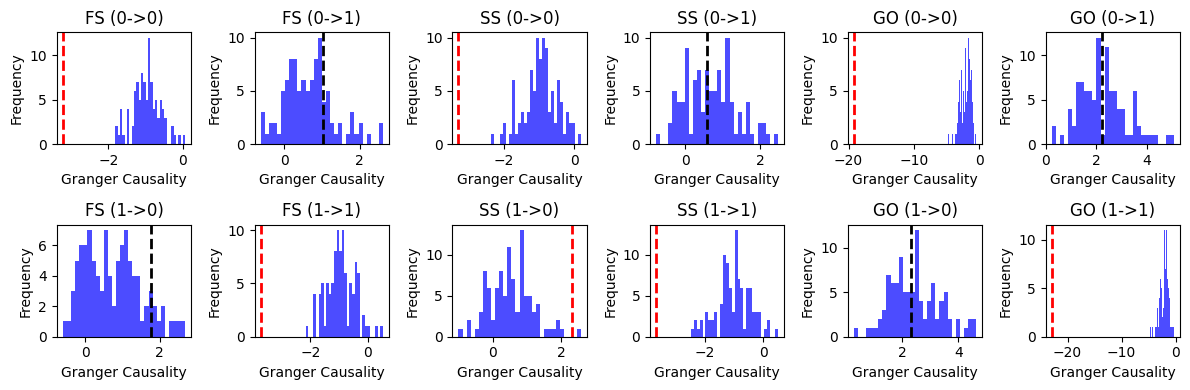

In [12]:
# Initialize dictionaries to store p-values and histograms
p_values = {cond: np.zeros((neurons, neurons)) for cond in conditions}

fig=plt.figure(figsize=(12,4)) 
gs = GridSpec(2, 6)

# Compute p-values for each matrix in each condition
for cond_idx, cond in enumerate(conditions):
    observed_gc_matrix = np.mean(signed_gc_matrices[cond], axis=0)  # Average across subjects
    permuted_gc_array = np.array(permuted_signed_gc_matrices[cond])  # Convert to numpy array (shape: n_permutations x neurons x neurons)
    
    for i in range(neurons):
        for j in range(neurons):
            ax = fig.add_subplot(gs[i,cond_idx*2+j])
            observed_value = observed_gc_matrix[i, j]
            null_distribution = permuted_gc_array[:, i, j]

            # Compute two-tailed p-value
            p_values[cond][i, j] = (np.sum(np.abs(null_distribution) >= np.abs(observed_value)) + 1) / (n_permutations + 1)

            # Plot histogram of null distribution with observed value
            plt.hist(null_distribution, bins=30, alpha=0.7, color='blue', label='Permuted GC')
            col='black'
            if p_values[cond][i, j]<0.05:
                col='red'
            plt.axvline(x=observed_value, color=col, linestyle='dashed', linewidth=2, label='Observed GC')
            plt.title(f"{cond} ({i}->{j})")
            plt.xlabel("Granger Causality")
            plt.ylabel("Frequency")
    plt.tight_layout()

# Print computed p-values for inspection
for cond, p_val_matrix in p_values.items():
    print(f"P-values for condition {cond}:")
    print(p_val_matrix)


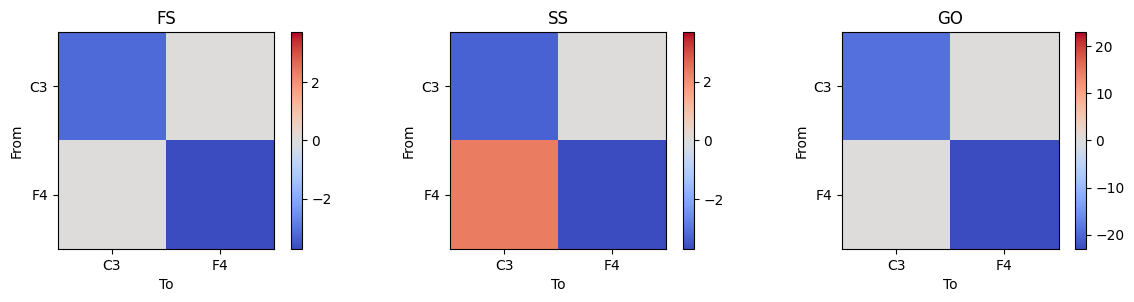

In [13]:
fig=plt.figure(figsize=(12,3))
gs = GridSpec(1, 3)
for cond_idx, cond in enumerate(signed_gc_matrices):
    ax = fig.add_subplot(gs[0,cond_idx])
    gc_mat=np.mean(np.array(signed_gc_matrices[cond]),axis=0)
    gc_mat[p_values[cond]>=0.05]=0
    maxabs=np.max(np.abs(gc_mat[:]))
    # Display results
    im=plt.imshow(gc_mat, cmap='coolwarm', interpolation='none', clim=[-maxabs, maxabs])
    plt.colorbar()
    plt.title(cond)
    plt.xlabel("To")
    plt.ylabel("From")
    plt.xticks([0,1])
    ax.set_xticklabels(['C3','F4'])
    plt.yticks([0,1])
    ax.set_yticklabels(['C3','F4'])
plt.tight_layout()